<h2>Exercise 8: Variational Monte Carlo, Path Integral Monte Carlo<h2>

<h5>8-1: Implement a Monte Carlo sampling algorithm for the computation of the mean value of the given hamiltonian in a trial ground state<h5>

We aim at computing the mean value of hamiltonian $V(x)+T$, with $V(x) = x^4-\frac{5}{2}x^2$ and $T$ the kinetic energy. We choose a trial ground state $\psi^{\sigma, \mu}(x) = e^{\frac{(x-\mu)^2}{2\sigma^2}} + e^{\frac{(x+\mu)^2}{2\sigma^2}}$, so that evaluating the kinetic energy functional $-\frac{1}{2}\frac{\partial^2}{\partial x ^2}$ at the trial wavefunction yelds $T[\psi^{\sigma,\mu}](x) = -\frac{1}{2}\left(e^{\frac{(x-\mu)^2}{2\sigma^2}}\left(\left(\frac{x-\mu}{\sigma}\right)^2 - 1\right) + e^{\frac{(x+\mu)^2}{2\sigma^2}}\left(\left(\frac{x-\mu}{\sigma}\right)^2 - 1 \right)  \right)\frac{1}{\sigma^2}$. The square of former formula will be passed to a Metropolis instance in order to regulate the acceptance of newly sampled positions, whereas $\frac{\left(V(x) + T[\psi^{\sigma,\mu}](x)\right)}{|\psi^{\sigma, \mu}(x)|} = \frac{H[\psi^{\sigma,\mu}](x)}{|\psi^{\sigma,\mu}(x)|}$ will be the contribution that each sampled point gives to average energy. Pratically, we are implementing the very definition of quantum average. It should be noticed that energies are all expressed in units of  of $\frac{\hbar^2}{m\times\left[l\right]^2}$, where l is a length unit, since this makes the kinetic energy functional adimensional. 

Next, we use the code in LNS_Exercise08 to calculate the numerical "exact" solution with the eighenvalues-eighenvectors method for a discretized system:

In [1]:
import numpy as np

#import matplotlib.pylab as plt
#import time
#from IPython import display
#%matplotlib inline


In [2]:
##code for numerical solution, copied from LSN_Exercise_08
def Vpot(x):
    return (x**2 - 2.5)*x**2
    #return 0.5*x**2

hbar = 1
m = 1
a = 10
N = 1000 # number of iterations

# Step sizes
x = np.linspace(-a/2, a/2, N)
dx = x[1] - x[0] # the step size
V = Vpot(x)

# The central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2

CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
# np.diag(np.array,k) construct a "diagonal" matrix using the np.array
# The default is k=0. Use k>0 for diagonals above the main diagonal, 
# and k<0 for diagonals below the main diagonal

# Hamiltonian matrix
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

# Compute eigenvectors and their eigenvalues
E,psi = np.linalg.eigh(H)

# Take the transpose & normalize
psi = np.transpose(psi)
psi = psi/np.sqrt(dx)


print("Ground state energy: ", E[0])
print("1st excited state energy: ", E[1])
print("2nd excited state energy: ", E[2])



Ground state energy:  -0.46046587969271535
1st excited state energy:  0.0974247133176099
2nd excited state energy:  1.9717331343930198


In [3]:

#with open("exercices/output/dir08/trial_wave.dat") as file:
#    psi , T , V= np.loadtxt(file, unpack=True)

class functions:
    def __init__ (self, pars):
        self.mu = pars[0]
        self.sigma = pars[1]
    
    def wavefunction (self, x):
        return (np.exp (-((x-self.mu)/self.sigma)**2/2.) + np.exp (-((x+self.mu)/self.sigma)**2/2.))**2
    def potential (self, x):
        return x**4 - 5./2. * x**2
    def T (self, x): 
        return -0.5 * (np.exp(-((x-self.mu)/self.sigma)**2/2.) * ((self.mu - x)**2  - self.sigma**2 ))/self.sigma**4 \
                    + (np.exp(-((x+self.mu)/self.sigma)**2/2.) * ((self.mu + x)**2 - self.sigma**2 ))/self.sigma**4         
    





points = np.loadtxt ("exercices/output/dir08/points.dat")
energies, errors, acc = np.loadtxt ("exercices/output/dir08/Energy_and_acceptance.dat", unpack=True)
parameters = np.loadtxt ("exercices/output/dir08/Mu_Sigma.dat") 
#xwave, wave = np.loadtxt ("trials/wavefuntion.dat", unpack=True) 
  


<h5>8-2: optimize the trial wavefunction for the lowest energy<h5>

A standard "quadrature" method is used: a square grid of $10\times10$ points is set up, each point corresponding to a different couple of $(\mu,\sigma)$ values. For each point, the average energy for $\psi^{\mu,\sigma}$ is computed as described above; afterwards, the grid is centered on the lowest energy point, and the range restricted by a constant factor. Tunable parameters of the algorithm are the dasired precision (ratio of the initial range to the final one), the number of iterations, and obviously the initial center and range(s) of the grid. The last ones were chosen to be $(\mu,\sigma) = (1,1)$ and  $(1,0.95)$  respectively

found parameters: mu = 0.642002, sigma = -0.51088


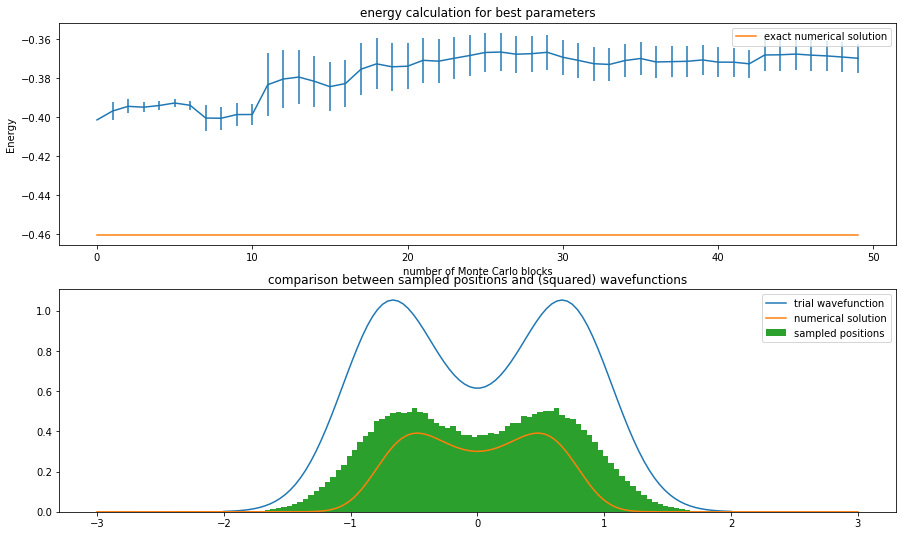

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure (figsize = (15, 9))  

axEn = plt.subplot (211)
axEn.errorbar (range (energies.shape[0]), energies, errors)
axEn.plot (range (energies.shape[0]), np.ones(energies.shape)*E[0], label="exact numerical solution") #plot expected value (it is a lower bound, actually)
axEn.set_title ("energy calculation for best parameters")
axEn.set_xlabel ("number of Monte Carlo blocks")
axEn.set_ylabel ("Energy ")
axEn.legend()


funcComputer = functions(parameters[-4][:2])
axHist = plt.subplot (212)
axHist.set_title ("comparison between sampled positions and (squared) wavefunctions")
axHist.plot (x, funcComputer.wavefunction (x),
             label="trial wavefunction")
axHist.plot (np.linspace (-3, 3, psi[0].shape[0]), psi[0]**2, label="numerical solution" )
#axHist.plot (xwave, wave ** 2, label="trial" )
cols, bars, bins = axHist.hist (points.flatten(), bins=100, density=True, label="sampled positions")
x = np.linspace (-2,2,100)
axHist.legend()        
        
    
print ("found parameters: mu = {}, sigma = {}".format (parameters [-1,0], parameters [-1,1]))  








A negative value of sigma was found. This must be no wonder since only the squared value of sigma is used for both the acceptance functor and energy calculation.

As expected, the sampled positions distribution reflects (is a normalized version of) the (square of the) analytical trial wave function used for the Metropolis acceptance. It is different to the "exact" numerical solution of the problem; as a consequence, the energy is higer (plot above)  

<h5>8-3: comparison with results from QMC path integral methods / results for finite T<h5>

in the cell below, we plot the energy value obtained from the computation at T = 0 with the provided simulation code

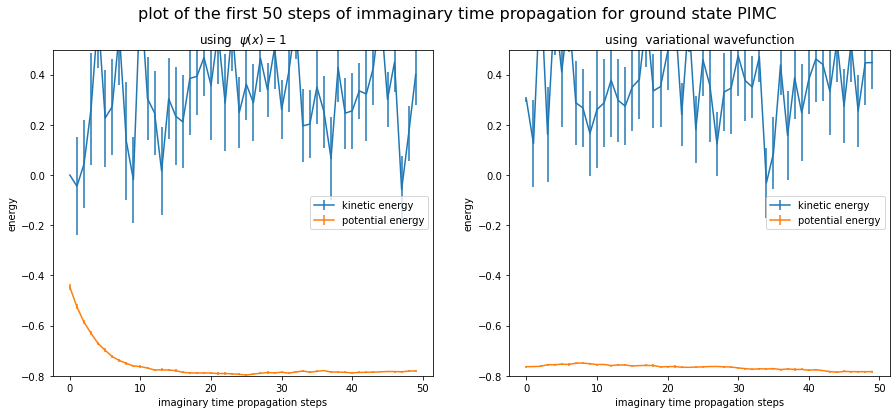

In [6]:
dirname = "exercices/output/dir08"

dirPIGS = dirname + "/PIGS"
keys = ["kinetic", "potential"]
suffixes = ["_1", ""]
wavefuncTitles = [" $\psi (x)  = 1$", " variational wavefunction"]



quantities = []
for suffix in suffixes:
    quantities.append ({key : np.loadtxt (dirPIGS + '/' + key + suffix + ".dat" , usecols=(0,1,2), unpack=True ) for key in keys})
    

fig, axes = plt.subplots (1,2)
fig.set_size_inches (15,6)
fig.suptitle ("plot of the first 50 steps of immaginary time propagation for ground state PIMC", fontsize=16)

for ax, wavefuncTitle, qdict in zip (axes, wavefuncTitles, quantities):
    for key in keys:
        ax.errorbar (qdict [key] [0][:50], qdict [key] [1][:50], qdict [key] [2][:50], 
                     label=key+" energy")
    ax.set_title ("using " + wavefuncTitle)
    ax.set_xlabel ("imaginary time propagation steps")
    ax.set_ylabel ("energy")
    ax.set_ylim (-0.8,0.5)
    ax.legend()
    
    
    



The immaginary time for propagation is reduced to almost no steps by the use of the variational wavefunction.  

For comparison, we plot the results obtained for an elastic potential and the corresponding exact wavefunction. One can see that in this case there is no need of preliminary immaginary time propagation for removing the excited states: the system is at equilibrium from the beginning. This shows up in the plot by the fact that the potential energy plot is a straight line

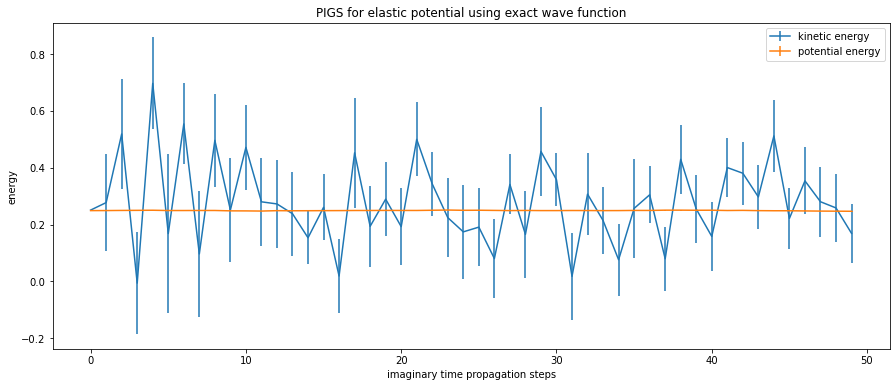

In [72]:
#quantityel = {key : dirPIGS + 'elastic/' + key + ".dat" for key in keys }

quantityel = {key : np.loadtxt (dirPIGS + 'elastic/' + key + "_u.dat" , usecols=(0,1,2), unpack=True ) for key in keys}

for key in keys:
    plt.errorbar (quantityel [key] [0][:50], quantityel [key] [1][:50], quantityel [key] [2][:50], 
                 label=key+" energy")
plt.title ("PIGS for elastic potential using exact wave function")
plt.xlabel ("imaginary time propagation steps")
plt.ylabel ("energy")
plt.legend()
plt.gcf().set_size_inches(15,6)

next, we plot the histogram of sampled position as a function of varying temperature

In [10]:
import os
import re

dirPIMC = dirname + "/PIMC"

regHist = re.compile (r"probability")
regTemp = re.compile (r"(?<=_T)(.*)(?=.dat)")

listnames = [filename for filename in os.listdir(dirPIMC) if regHist.search(filename) ]

#print (listnames)

Hdict = {float(regTemp.search(filename).group()) : np.loadtxt (dirPIMC + '/' + filename, unpack=True) for filename in listnames}

#hists = Hdict.values()
print ("temperatures: ", list(Hdict.keys()))


temperatures:  [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 10.0, 10.1, 10.6, 11.1, 11.6, 12.1, 12.6, 13.1, 13.6, 14.1, 14.6, 15.1, 15.6, 16.1, 16.6, 17.1, 17.6, 18.1, 18.6, 19.1, 19.6, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 20.1, 20.6, 21.1, 21.6, 22.1, 22.6, 23.1, 23.6, 24.1, 24.6, 25.1, 25.6, 26.1, 26.6, 27.1, 27.6, 28.1, 28.6, 29.1, 29.6, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 30.1, 30.6, 31.1, 31.6, 32.1, 32.6, 33.1, 33.6, 34.1, 34.6, 35.1, 35.6, 36.1, 36.6, 37.1, 37.6, 38.1, 38.6, 39.1, 39.6, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 40.1, 40.6, 41.1, 41.6, 42.1, 42.6, 43.1, 43.6, 44.1, 44.6, 45.1, 45.6, 46.1, 46.6, 47.1, 47.6, 48.1, 48.6, 49.1, 49.6, 5.0, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6.0, 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7.0, 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8.0, 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9.0, 9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9]


<IPython.core.display.Javascript object>


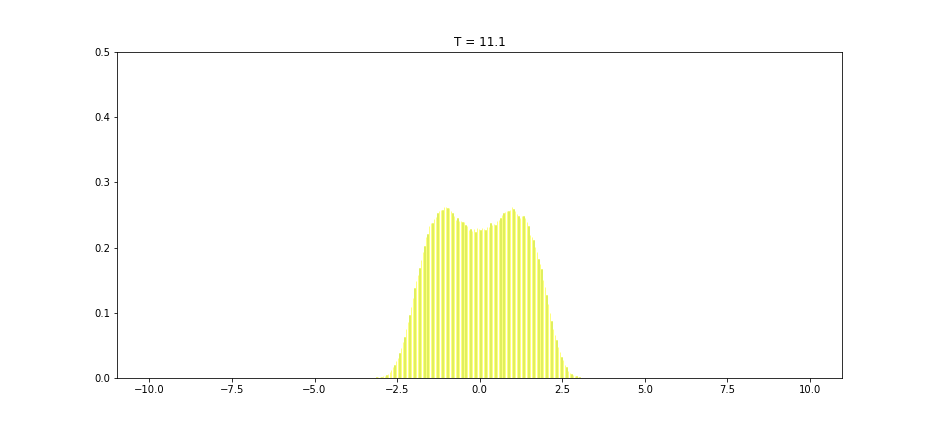

In [8]:

%matplotlib notebook
%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib.animation as animation

firstitem = next(iter (Hdict.items()))

            
fig, ax = plt.subplots()
fig.set_size_inches (13,6)
bar_container = ax.bar(firstitem[1][0], firstitem[1][1], width=0.01,
                              ec="yellow", fc="green", alpha=0.5)
title = ax.set_title ("T = {}".format(firstitem[0]))

def animate( item ):
    for height, rect in zip (item [1] [1], bar_container.patches):
        rect.set_height (height)
    title = ax.set_title ("T = {}".format (item [0]))
    return [bar_container.patches, title]  
    


ax.set_ylim(top=0.5)  # set safe limit to ensure that all data is visible.

ani = animation.FuncAnimation(fig, animate , frames=sorted((Hdict).items()),
                              repeat=True, blit=True)
plt.show()

At high temperature the histogram becomes flat and more spread. This may be due to the fact that odd eighenstates (with a node in the origin) become superimposed to even ones (possibly nonzero in the origin)